In [68]:
import sys
sys.path.append('../')

In [69]:
import tensorflow as tf
from RCWA.Domain import Domain
from RCWA.Modes import Modes
from RCWA.EigenMode import EigenMode
from RCWA.ScatterMat import ScatterMatBuilder
from RCWA.Device import SlantGrating
from RCWA import Utils
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

In [70]:
from RCWA.Domain import Domain

In [104]:
period = 2

n1 = 3
n2 = 1

er1 = n1**2
er2 = n2**2
ur1 = 1
ur2 = 1

domain = Domain()
domain.set_period_centered(period, period)

modes = Modes(domain)
modes.set_harmonics(10, 10)


In [105]:
modes.set_incidence_AOI_POI(
    AOI=np.deg2rad(0),
    POI=np.deg2rad(0))
modes.set_wavelength(0.530)

# Default Matrix
sbuilder = ScatterMatBuilder(modes)
ref_mode = EigenMode(modes)
trn_mode = EigenMode(modes)
ref_mode.from_homogeneous(er1, ur1)
trn_mode.from_homogeneous(er2, ur2)
Sref = sbuilder.BuildScatterRef(ref_mode)
Strn = sbuilder.BuildScatterTrn(trn_mode)

Sglobal = Sref


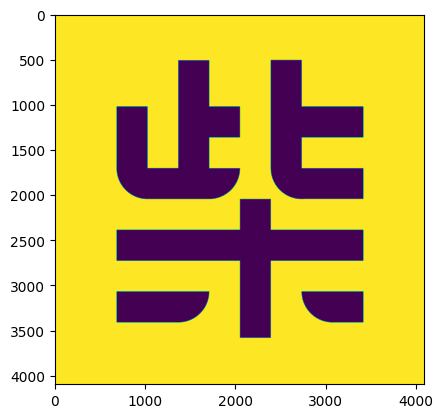

In [106]:
img = np.array(Image.open('./logo.png'))

nx = img.shape[1]  # Number of sample points along the x-axis
ny = img.shape[0]  # Number of sample points along the y-axis

# Generating x and y coordinates
x, y = domain.get_coordinate(nx, ny)
mask = img[:, :, 0] < 128
# Displaying the mask
plt.imshow(mask)
plt.show()

n0 = 1  # Refractive index of the background medium
n1 = np.sqrt(2.5)  # Refractive index of the region of interest

# Defining the dielectric constant (epsilon) and permeability (mu) distributions
er = (er2 - er1) * mask + er1  # Dielectric constant distribution
eigenmode = EigenMode(modes)
eigenmode.from_material_er(er)
S = sbuilder.BuildScatter(eigenmode, 1)
Sglobal = Sglobal @ S
Sglobal = Sglobal @ Strn

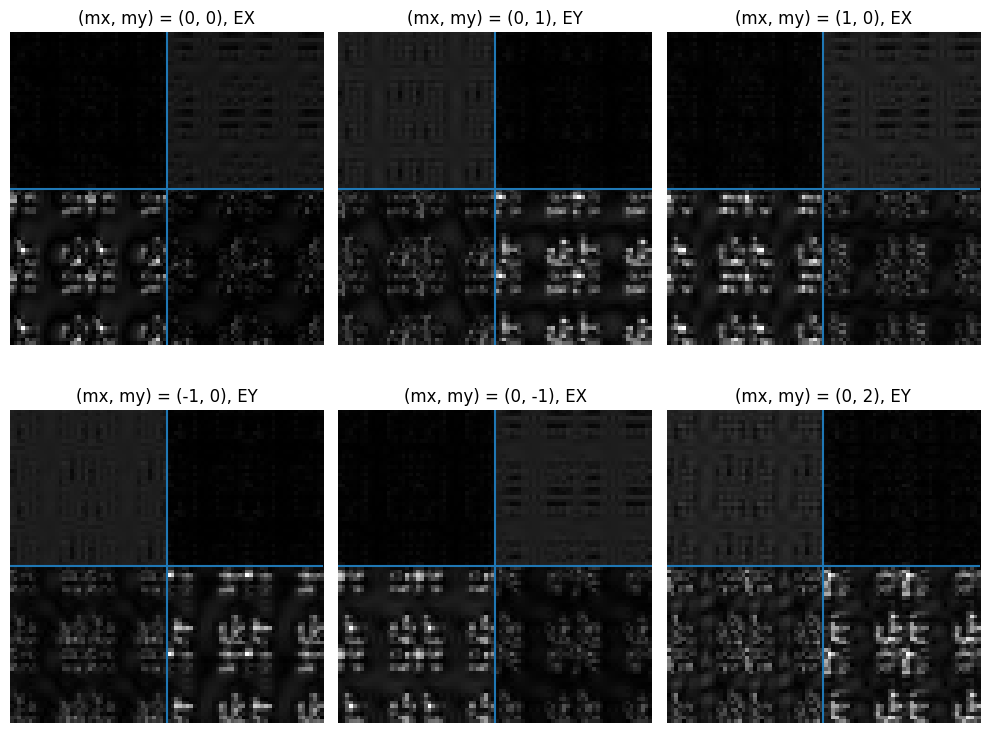

In [107]:
plt.figure(figsize=(10, 8))
mode_order = np.argsort(np.abs(modes.mx)+np.abs(modes.my))
# Loop through the range 20
for i in range(6):
    # Create subplots in a 5x4 grid
    plt.subplot(2, 3, i+1)
    eigenmode.vis_mode(mode_order[i//1], i % 2)
plt.tight_layout()
plt.show()

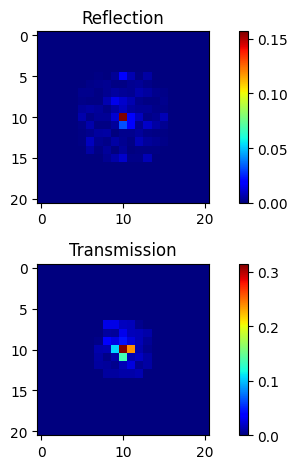

1.9879732062319473
Error: -0.9879732062319473


In [108]:
# Incidence
delta = (modes.mx == 0)*(modes.my == 0)

# Set amplitudes for s and p polarizations
pol_angle = np.deg2rad(90)

amp_s = tf.sin(pol_angle)  # 90 degree
amp_p = tf.cos(pol_angle)  # 0 degree

# Calculate the polarization vector based on s and p amplitudes
pol = modes.pol_vec_p * amp_p + modes.pol_vec_s * amp_s

# Calculate the incident electric field components
Einc = tf.cast(
    tf.concat([delta*pol[0], delta*pol[1]], 0), tf.dtypes.complex128)
Einc_z = delta*pol[2]

# Calculate the incident intensity
Iinc = tf.reduce_sum(np.abs(Einc)**2)+tf.reduce_sum(np.abs(Einc_z)**2)

# Calculate the longitudinal wave vector components
kz_r = tf.sqrt((n1**2-modes.kx**2-modes.ky**2).astype('complex'))
kz_t = tf.sqrt((n2**2-modes.kx**2-modes.ky**2).astype('complex'))


# Calculate the electric field components using the scattering matrix
Eref = tf.reshape((Sglobal.value[0]@Einc[:, None]), [2, -1])
Etrn = tf.reshape((Sglobal.value[2]@Einc[:, None]), [2, -1])

# Calculate the longitudinal electric field components
Eref_z = -(Eref[0]*modes.kx+Eref[1]*modes.ky)/kz_r
Etrn_z = -(Etrn[0]*modes.kx+Etrn[1]*modes.ky)/kz_t

# Calculate the reflected and transmitted intensities
Iref = tf.reduce_sum(tf.abs(Eref)**2, 0)+tf.abs(Eref_z)**2
Itrn = tf.reduce_sum(tf.abs(Etrn)**2, 0)+tf.abs(Etrn_z)**2

# Calculate the reflection and transmission coefficients
R = Iref*tf.math.real(kz_r)/modes.k0z/Iinc
T = Itrn*tf.math.real(kz_t)/modes.k0z/Iinc


# Reshape the reflection and transmission coefficients into 2D arrays
R_2d = tf.reshape(R, [modes.num_modes_y, modes.num_modes_x])
T_2d = tf.reshape(T, [modes.num_modes_y, modes.num_modes_x])

# Plot the reflection and transmission coefficients
plt.subplot(2, 1, 1)
plt.title("Reflection")
plt.imshow(R_2d, cmap='jet', vmin=0)
plt.colorbar()
plt.subplot(2, 1, 2)
plt.title("Transmission")
plt.imshow(T_2d, cmap='jet', vmin=0)
plt.colorbar()
plt.tight_layout()
plt.show()

# Calculate the sum of reflection and transmission coefficients
print(np.sum(R+T))
print("Error:", 1-np.sum(R+T))


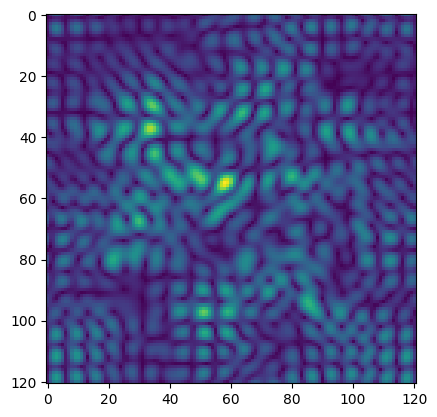

In [109]:
c = tf.concat([Etrn[0], tf.zeros(modes.num_modes, dtype=tf.dtypes.complex128)], 0)
c = tf.linalg.solve(eigenmode.W, c[:, None])
z = 0.5
c = tf.exp(-eigenmode.LAM * z * modes.k0)[:, None] * c
e = eigenmode.W @ c
e = tf.reshape(e[:modes.num_modes], [modes.num_modes_x, modes.num_modes_y])
e = tf.signal.fftshift(e)
a = 50
e = tf.pad(e, [[a, a], [a, a]])
plt.imshow(tf.abs(tf.signal.ifft2d(e)))

In [114]:
# c0 = tf.concat([Etrn[0], tf.zeros(modes.num_modes, dtype=tf.dtypes.complex128)], 0)
# c0 = tf.linalg.solve(eigenmode.W, c0[:, None])
c0 = np.zeros([modes.num_modes*2, 1])
order = np.argsort(np.abs(1-np.abs(eigenmode.LAM)))
mask = np.abs(np.abs(eigenmode.LAM)-1)<1e-1
c0[mask, 0] = 1

dt = np.pi*2/100
dz = modes.wavelength/100
for i in range(400):
    z = i*dz
    t = i * dt
    c = tf.exp(-eigenmode.LAM * z * modes.k0)[:, None] * c0
    # c = tf.exp(-1j*t) * c0
    e = eigenmode.W @ c
    e = tf.reshape(e[:modes.num_modes], [modes.num_modes_x, modes.num_modes_y])
    e = tf.signal.fftshift(e)
    a = 200
    e = tf.pad(e, [[a, a], [a, a]])
    # plt.imshow(tf.abs(tf.signal.ifft2d(e)))
    f = tf.math.abs(tf.signal.ifft2d(e))
    f = f / (np.max(f)+1e-5)
    img2 = Image.fromarray(np.uint8(f*256))
    img2.save(f'./output/{i:04d}.png')

In [111]:
1/np.max(tf.math.real(tf.signal.ifft2d(e)))

25213.099363808567